In [1]:
!pip install lightgbm --install-option=--gpu
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from tqdm.notebook import tqdm
from IPython.display import clear_output
!pip install catboost
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension
import catboost 
from catboost import CatBoostClassifier
sns.set()
clear_output()
%matplotlib inline

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Данные

In [ ]:
# скачиваем файлы
!wget --no-check-certificate 'https://www.dropbox.com/s/5iuef7c9ljj84t6/train_transaction.csv?dl=0' -O train_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/cmy01z5fw7ohlmd/train_identity.csv?dl=0' -O train_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/7thqkuxnwsa7njj/test_transaction.csv?dl=0' -O test_transaction.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/b40nvbb9e2usd5w/test_identity.csv?dl=0' -O test_identity.csv
!wget --no-check-certificate 'https://www.dropbox.com/s/arkyoz0bel8z4d2/sample_submission.csv?dl=0' -O sample_submission.csv

In [ ]:
def reduce_mem_usage(df):
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in tqdm(df.columns):
        if df[col].dtype != object:  # Exclude strings

            # make variables for Int, max and min
            IsInt = False
            col_max_value = df[col].max()
            col_min_value = df[col].min()

            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
                NAlist.append(col)
                df[col].fillna(col_min_value - 1, inplace=True)

            # test if column can be converted to an integer
            col_as_int = df[col].fillna(0).astype(np.int64)
            diff = (df[col] - col_as_int)
            diff = diff.sum()
            if np.abs(diff) < 0.01:
                IsInt = True

            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if col_min_value >= 0:
                    if col_max_value < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif col_max_value < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif col_max_value < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if col_min_value > np.iinfo(np.int8).min and col_max_value < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif col_min_value > np.iinfo(np.int16).min and col_max_value < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif col_min_value > np.iinfo(np.int32).min and col_max_value < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif col_min_value > np.iinfo(np.int64).min and col_max_value < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)    

            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)

    return df, NAlist

In [ ]:
INPUT_DIR = '.'

train_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'train_transaction.csv'))
train_identity = pd.read_csv(os.path.join(INPUT_DIR, 'train_identity.csv'))
test_transaction = pd.read_csv(os.path.join(INPUT_DIR, 'test_transaction.csv'))
test_identity = pd.read_csv(os.path.join(INPUT_DIR, 'test_identity.csv'))
sample_submission = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

df_train = train_transaction.merge(train_identity, how='left', on='TransactionID')
del train_transaction, train_identity
#df_train, df_train_NAlist = reduce_mem_usage(df_train)

df_test = test_transaction.merge(test_identity, how='left', on='TransactionID')
del test_transaction, test_identity
#df_test, df_test_NAlist = reduce_mem_usage(df_test)

Для того, чтобы улучшать качество предсказаний, можно не только менять модели и подбирать их гиперпараметры, но и модифицировать выборку. Это можно делать разными техниками - преобразования признаков, их отбор, извлечение новых и т.п. Это может помочь в силу того, что модель иногда не способна увидеть закономерности, скрытые внутри признаков, в отличие от человека, который может выделить их вручную. Подобные операции даже могут привести к появлению так называемых "magic features": их добавление к выборке может дать сильный прирост в качестве. Пример: [magic features от золотого призера одного из соревнований](https://www.kaggle.com/jturkewitz/magic-features-0-03-gain).

Посмотрим на распределение значений числового признака `'TransactionAmt'` в обучающей выборке:

In [ ]:
df_test.TransactionID

,TransactionID,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,card6,addr1,addr2,dist1,dist2,P_emaildomain,R_emaildomain,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,...,id_01,id_02,id_03,id_04,id_05,id_06,id_07,id_08,id_09,id_10,id_11,id_12,id_13,id_14,id_15,id_16,id_17,id_18,id_19,id_20,id_21,id_22,id_23,id_24,id_25,id_26,id_27,id_28,id_29,id_30,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,3404559,10540826,311.95,W,9500,321.0,150.0,visa,226.0,debit,272.0,87.0,4.0,NaN,gmail.com,NaN,185.0,168.0,0.0,0.0,126.0,110.0,0.0,0.0,144.0,0.0,143.0,0.0,522.0,142.0,131.0,131.0,1.0,592.0,1.0,NaN,NaN,NaN,NaN,482.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3404560,10540850,59.00,W,15497,490.0,150.0,visa,226.0,debit,299.0,87.0,227.0,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,2.0,1.0,5.0,1.0,27.0,27.0,1.0,1.0,1.0,NaN,NaN,NaN,NaN,27.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3404561,10540855,59.00,W,7919,194.0,150.0,mastercard,166.0,debit,325.0,87.0,NaN,NaN,NaN,NaN,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3404562,10540864,160.50,W,16075,514.0,150.0,mastercard,102.0,credit,123.0,87.0,4.0,NaN,yahoo.com,NaN,144.0,146.0,0.0,0.0,93.0,115.0,0.0,0.0,108.0,0.0,117.0,0.0,455.0,113.0,0.0,NaN,NaN,166.0,166.0,NaN,NaN,NaN,NaN,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3404563,10540871,932.00,W,11639,321.0,150.0,visa,226.0,debit,299.0,87.0,NaN,NaN,sbcglobal.net,NaN,1.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,2.0,1.0,1.0,1.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172976,3577535,15811047,49.00,W,6550,NaN,150.0,visa,226.0,debit,272.0,87.0,48.0,NaN,NaN,NaN,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,3.0,2.0,29.0,29.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN,56.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172977,3577536,15811049,39.50,W,10444,225.0,150.0,mastercard,224.0,debit,204.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172978,3577537,15811079,30.95,W,12037,595.0,150.0,mastercard,224.0,debit,231.0,87.0,NaN,NaN,gmail.com,NaN,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
172979,3577538,15811088,117.00,W,7826,481.0,150.0,mastercard,224.0,debit,387.0,87.0,3.0,NaN,aol.com,NaN,1.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,2.0,0.0,1.0,1.0,5.0,1.0,22.0,22.0,0.0,22.0,0.0,NaN,NaN,NaN,NaN,22.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
df_train['TransactionAmt_log'] = np.log1p(df_train['TransactionAmt'])
df_test['TransactionAmt_log'] = np.log1p(df_test['TransactionAmt'])

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


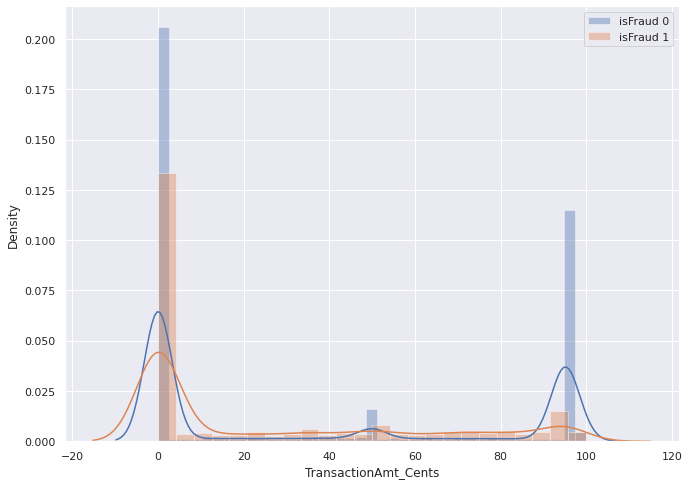

In [ ]:
df_train['TransactionAmt_Cents'] = np.modf(df_train['TransactionAmt'])[0] * 100
df_test['TransactionAmt_Cents'] = np.modf(df_test['TransactionAmt'])[0] * 100

plt.figure(figsize=(11, 8))
sns.distplot(df_train[df_train['isFraud'] == 0]['TransactionAmt_Cents'], label='isFraud 0')
sns.distplot(df_train[df_train['isFraud'] == 1]['TransactionAmt_Cents'], label='isFraud 1')
plt.legend(loc='best')
plt.show()

Из имеющихся признаков можно извлекать новые. Многие признаки анонимизированы, однако есть достаточно понятные - скажем, почта или OS устройства, с которого совершалась транзакция. Извлечем новый признак - окончание почты, который может нести в себе какую-нибудь информацию - например, информацию о стране (если название домена заканчивается на `.fr`).

In [ ]:
for col in ['P_emaildomain', 'R_emaildomain']:
    df_train[col + '_suffix'] = df_train[col].map(lambda x: str(x).split('.')[-1])
    df_test[col + '_suffix'] = df_test[col].map(lambda x: str(x).split('.')[-1])

df_train[['P_emaildomain', 'P_emaildomain_suffix', 'R_emaildomain', 'R_emaildomain_suffix']].tail(10)

,P_emaildomain,P_emaildomain_suffix,R_emaildomain,R_emaildomain_suffix
417549,gmail.com,com,NaN,nan
417550,gmail.com,com,NaN,nan
417551,att.net,net,NaN,nan
417552,anonymous.com,com,NaN,nan
417553,yahoo.com,com,NaN,nan
417554,gmail.com,com,NaN,nan
417555,gmail.com,com,NaN,nan
417556,hotmail.com,com,hotmail.com,com
417557,gmail.com,com,NaN,nan
417558,gmail.com,com,NaN,nan


Новые признаки можно извлекать на основании сочетаний некоторых имеющихся. Например, добавим в данные признак, отвечающий за то, совпадают ли домены покупателя и получателя - вдруг это что-то даст.

In [ ]:
df_train['same_emaildomain'] = (df_train['P_emaildomain'] == df_train['R_emaildomain']).astype('uint8')
df_test['same_emaildomain'] = (df_test['P_emaildomain'] == df_test['R_emaildomain']).astype('uint8')
df_train[['P_emaildomain', 'R_emaildomain', 'same_emaildomain']].tail()

,P_emaildomain,R_emaildomain,same_emaildomain
417554,gmail.com,NaN,0
417555,gmail.com,NaN,0
417556,hotmail.com,hotmail.com,1
417557,gmail.com,NaN,0
417558,gmail.com,NaN,0


Можно комбинировать признаки - производить арифметические операции между числовыми признаками, использовать сочетания категориальных. Такие комбинации иногда позволяют породить мощные признаки. Например, если какие-то из признаков `'card1'-'card6'` и `'addr1'-'addr2'` содержат важную информацию о клиенте, то объединение некоторых из них может помочь лучше идентифицировать клиента и факт мошенничества в транзакции. Главное не переусердствовать - если признаки содержат очень много категорий, то их объединение скорее всего приведет к появлению признака с колоссальным количеством категорий, что в свою очередь может привести к ухудшению качества. Из полученного признака тогда можно извлечь какую-то информацию с помощью группировки и агрегирования, но оставлять его просто так, скорее всего, опасно. Чтобы понять, о чем речь, попробуйте объединить признаки `'card1'` и `'card2'` - это два самых важных признака для модели из бейзлайна.

В данном случае скомбинируем признаки `'card3'` и `'card5'` - они входят в топ-50 важных признаков для модели из бейзлайна.

In [ ]:
df_train['card3_card5'] = df_train['card3'].astype(str) + '_' + df_train['card5'].astype(str)
df_test['card3_card5'] = df_test['card3'].astype(str) + '_' + df_test['card5'].astype(str)
df_train[['card3', 'card5', 'card3_card5']].head(10)

,card3,card5,card3_card5
0,150.0,142.0,150.0_142.0
1,150.0,102.0,150.0_102.0
2,150.0,166.0,150.0_166.0
3,150.0,117.0,150.0_117.0
4,150.0,102.0,150.0_102.0
5,150.0,226.0,150.0_226.0
6,150.0,166.0,150.0_166.0
7,150.0,226.0,150.0_226.0
8,150.0,226.0,150.0_226.0
9,150.0,224.0,150.0_224.0


In [ ]:
for col in ['card3', 'card5', 'card3_card5']:
    print('Number of categories in train for {}: {}'.format(col, df_train[col].nunique()))

Number of categories in train for card3: 105
Number of categories in train for card5: 110
Number of categories in train for card3_card5: 553


Можно также закодировать категориальные признаки, исходя из их частоты встречаемости в выборке.

In [ ]:
for col in ['card1', 'card2']:
    card_freq = df_train[col].value_counts().to_dict()
    df_train['{}_cnt'.format(col)] = df_train[col].map(card_freq)
    df_test['{}_cnt'.format(col)] = df_test[col].map(card_freq)
df_train[['card1', 'card1_cnt', 'card2', 'card2_cnt']].head(10)

Наконец, можно использовать агрегирование и группировку. Например, наряду с `'card1'` и `'card2'`, одним из важнейших признаков для модели в бейзлайне является `'TransactionAmt'`. Давайте добавим в данные признаки, отвечающие за среднюю, медианную, максимальную и минимальную суммы покупок для каждой категории в `'card1'` и `'card2'`.

In [ ]:
new_cols = []
for col in ['card1', 'card2']:
    for agg_type in ['mean', 'median', 'min', 'max']:
        agg_col_name = 'TransactionAmt_{}_{}'.format(col, agg_type)
        card_agg = df_train.groupby(col)['TransactionAmt'].agg([agg_type]).rename({agg_type: agg_col_name}, axis=1)
        df_train = df_train.merge(card_agg, how='left', on=col)
        df_test = df_test.merge(card_agg, how='left', on=col)
        new_cols.append(agg_col_name)
df_train[['TransactionAmt', 'card1'] + new_cols[:4] + ['card2'] + new_cols[4:]].head(10)

Напоследок отметим, что можно проводить также и отбор признаков - дело в том, что если в данных много неинформативных признаков, они могут лишь создать помехи при обучении. Способов отбора много, начиная от ручного и заканчивая специально разработанными для этого методами. В данном случае мы оставим все как есть.

После всех операций с признаками удалим столбец `'TransactionAmt'`, раз он уже есть у нас в логарифмированном виде - чтобы модель на него не отвлекалась.

In [ ]:
df_train.drop('TransactionAmt', axis=1, inplace=True)
df_test.drop('TransactionAmt', axis=1, inplace=True)

In [ ]:
for col in tqdm(df_train.columns.drop('isFraud')):
    if df_train[col].dtype == 'O':
        df_train[col] = df_train[col].fillna('unseen_category')
        df_test[col] = df_test[col].fillna('unseen_category')
        
        le = LabelEncoder()
        le.fit(list(df_train[col]) + list(df_test[col]))
        df_train[col] = le.transform(df_train[col])
        df_test[col] = le.transform(df_test[col])
        
        df_train[col] = df_train[col].astype('category')
        df_test[col] = df_test[col].astype('category')

    else:
        df_train[col] = df_train[col].fillna(-1)
        df_test[col] = df_test[col].fillna(-1)

In [ ]:
from google.colab import drive
drive.mount('drive')
df_train.to_csv()
df_train.to_csv('df_train.csv')
!cp df_train.csv 'drive/My Drive/'
df_test.to_csv()
df_test.to_csv('df_test.csv')
!cp df_test.csv 'drive/My Drive/'

Mounted at drive


с готовыми датасетами



In [8]:
df_train = pd.read_csv('drive/My Drive/df_train.csv')
df_test = pd.read_csv('drive/My Drive/df_test.csv')

In [9]:
# выделяем фолды
month_length = 3600 * 24 * 30
fold0_idx = df_train[df_train['TransactionDT'] < df_train['TransactionDT'].min() + month_length].index
fold1_idx = df_train[(df_train['TransactionDT'].min() + month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 2 * month_length)].index
fold2_idx = df_train[(df_train['TransactionDT'].min() + 2 * month_length <= df_train['TransactionDT']) & (df_train['TransactionDT'] < df_train['TransactionDT'].min() + 3 * month_length)].index
fold3_idx = df_train[df_train['TransactionDT'].min() + 3 * month_length <= df_train['TransactionDT']].index
folds_idx = [fold0_idx, fold1_idx, fold2_idx, fold3_idx]

In [10]:
# выделяем идентификационный и временной признаки
id = df_test.TransactionID
df_train.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)
df_test.drop(['TransactionID', 'TransactionDT'], axis=1, inplace=True)

In [11]:
df_train.drop('Unnamed: 0', axis = 1, inplace = True)
df_test.drop('Unnamed: 0', axis = 1, inplace = True)

##Модели

In [ ]:
%%time
#import lightgbm as lgb
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'n_estimators': 2000,
    'seed': 13,
    'early_stopping_rounds': 100,
}

scores = []

feature_importances = pd.DataFrame()
feature_importances['feature'] = df_train.columns.drop('isFraud')

test_preds = []

for i in range(len(folds_idx)):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)

    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_val, y_val, reference=lgb_train)
    lgb_model = lgb.train(params, lgb_train, valid_sets=lgb_eval, verbose_eval=10)
    
    feature_importances['fold_{}'.format(i)] = lgb_model.feature_importance()

    y_pred = lgb_model.predict(X_val)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    y_test_pred = lgb_model.predict(df_test)
    test_preds.append(y_test_pred)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

In [13]:
from google.colab import drive
drive.mount('drive')
lgb_model.save_model('modelka.txt')
!cp modelka.txt 'drive/My Drive/'


Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
%%time
cols = df_train.columns
num_cols = df_train._get_numeric_data().columns
all = list(set(cols) - set(num_cols))

scores = []

for i in tqdm(range(len(folds_idx))):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)


    model = CatBoostClassifier(
    iterations=3000,
    random_seed=13,
    max_depth=13,
    custom_loss=['AUC'],
    task_type="GPU",
    devices='0:1',
    early_stopping_rounds=100
    )
    model.fit(
    X_train, y_train,
    cat_features=all,
    eval_set=(X_val, y_val),
    verbose_eval=True,
    )


    clear_output()
    y_pred = model.predict_proba(X_val)
    score_fold = roc_auc_score(y_val, y_pred[:,1])
    scores.append(score_fold)

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

In [ ]:
from google.colab import drive
drive.mount('drive')
model.save_model("model")
!cp model 'drive/My Drive/'

In [ ]:
import xgboost as xgb
scores = []

param = {
    'max_depth':12,
    'eta':.04,
    'gamma': 1,
    'objective':'binary:logistic',
    'eval_metric': 'auc',
    'nthread': -1,
    'tree_method': 'gpu_hist',

}
for i in tqdm(range(len(folds_idx))):
    X_train = df_train.drop(folds_idx[i], axis=0)
    y_train = X_train['isFraud'].values
    X_val = df_train.iloc[folds_idx[i]]
    y_val = X_val['isFraud'].values
    X_train = X_train.drop('isFraud', axis=1)
    X_val = X_val.drop('isFraud', axis=1)
    for i in X_train.columns:
        X_train[i] = X_train[i].astype('float')
    for i in X_train.columns:
        X_val[i] = X_val[i].astype('float')    



    dtrain = xgb.DMatrix(X_train, y_train)
    dtest = xgb.DMatrix(X_val, y_val)
    vallist = [(dtest, 'eval'), (dtrain, 'train')]
    num_round = 500
    boost = xgb.train(param, dtrain, num_round, vallist, early_stopping_rounds = 100)

    clear_output()
    y_pred = boost.predict(dtest)
    score_fold = roc_auc_score(y_val, y_pred)
    scores.append(score_fold)
    #y_test_pred = model.predict(df_test)
    #test_preds.append(y_test_pred)
    

for i in range(len(scores)):
    print('Fold {}, AUC-ROC: {:.5f}'.format(i, scores[i]))
print('CV AUC-ROC: {:.5f}'.format(np.mean(scores)))

In [ ]:
from google.colab import drive
drive.mount('drive')
boost.save_model('xgb')
!cp xgb 'drive/My Drive/'

##Импорт уже обученных и предсказания на ответах

In [6]:
from google.colab import drive
drive.mount('drive')
import lightgbm as lgb
import xgboost as xgb

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [7]:
bst = lgb.Booster(model_file='drive/My Drive/modelka.txt')
#dart1 = lgb.Booster(model_file='drive/My Drive/dart.txt') 
boost = xgb.Booster()  # init model
boost.load_model('drive/My Drive/xgb')
model1 = CatBoostClassifier() 
model1.load_model('drive/My Drive/model')

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.model_selection import KFold

y_train = df_train['isFraud']
X_train = df_train
X_train = X_train.drop('isFraud', axis=1)

lgb1 = bst.predict(X_train)
cat = model1.predict_proba(X_train)[:,1]
for i in X_train.columns:
        X_train[i] = X_train[i].astype('float')
xgboost = boost.predict(xgb.DMatrix(X_train))
new_X_train = pd.DataFrame({'lgb': lgb1, 'cat': cat, 'xgb':xgboost})

In [ ]:
lgb_test = bst.predict(df_test)
cat_test = model1.predict_proba(df_test)[:,1]
for i in df_test.columns:
        df_test[i] = df_test[i].astype('float')
xgboost_test = boost.predict(xgb.DMatrix(df_test))
new_X_test = pd.DataFrame({'lgb': lgb_test, 'cat': cat_test, 'xgb':xgboost_test})
new_X_test

In [ ]:
from google.colab import drive
drive.mount('drive')
new_X_test.to_csv('new_X_test.csv', index =False)
!cp new_X_test.csv 'drive/My Drive/'

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('drive')
new_X_train.to_csv('new_X_train.csv', index =False)
!cp new_X_train.csv 'drive/My Drive/'

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


Если не меняли исходные модели, то можно начинать отсюда

In [ ]:
new_X_train = pd.read_csv('drive/My Drive/new_X_train.csv')
new_X_test = pd.read_csv('drive/My Drive/new_X_test.csv')

In [ ]:
listok = []
for i in np.arange(0,1.1,0.1):
  for j in np.arange(0,1.1,0.1):
      if i-j> 0 :
        listok.append([i-j, j, 1-i])
print(listok)

[[0.1, 0.0, 0.9], [0.2, 0.0, 0.8], [0.1, 0.1, 0.8], [0.30000000000000004, 0.0, 0.7], [0.20000000000000004, 0.1, 0.7], [0.10000000000000003, 0.2, 0.7], [0.4, 0.0, 0.6], [0.30000000000000004, 0.1, 0.6], [0.2, 0.2, 0.6], [0.09999999999999998, 0.30000000000000004, 0.6], [0.5, 0.0, 0.5], [0.4, 0.1, 0.5], [0.3, 0.2, 0.5], [0.19999999999999996, 0.30000000000000004, 0.5], [0.09999999999999998, 0.4, 0.5], [0.6000000000000001, 0.0, 0.3999999999999999], [0.5000000000000001, 0.1, 0.3999999999999999], [0.4000000000000001, 0.2, 0.3999999999999999], [0.30000000000000004, 0.30000000000000004, 0.3999999999999999], [0.20000000000000007, 0.4, 0.3999999999999999], [0.10000000000000009, 0.5, 0.3999999999999999], [0.7000000000000001, 0.0, 0.29999999999999993], [0.6000000000000001, 0.1, 0.29999999999999993], [0.5, 0.2, 0.29999999999999993], [0.4, 0.30000000000000004, 0.29999999999999993], [0.30000000000000004, 0.4, 0.29999999999999993], [0.20000000000000007, 0.5, 0.29999999999999993], [0.09999999999999998, 0

In [ ]:
best_weight = 0
best_score = 0
for i in listok:
  score_fold = roc_auc_score(y_train, i[0]*new_X_train['cat'] + i[1]*new_X_train['lgb']+i[2]*new_X_train['xgb'])
  if score_fold > best_score:
    best_score = score_fold
    best_weight = i
  print("AUC:{}, weights:{}".format(score_fold, i))
print("Best AUC:{}, best weights:{}".format(best_score, best_weight))

In [ ]:
from google.colab import drive
drive.mount('drive')
sample_submission = pd.DataFrame()
pred= best_weight[0]*new_X_test['cat'] + best_weight[1]*new_X_test['lgb']+best_weight[2]*new_X_test['xgb']
sample_submission['TransactionID'] = id
sample_submission['isFraud'] = pred
print(sample_submission)
sample_submission.to_csv('cat+lgb+xgb6.csv', index=False)
!cp cat+lgb+xgb6.csv 'drive/My Drive/'